In [110]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from dateutil.rrule import rrule, DAILY
from dateutil.relativedelta import relativedelta
import datetime
from datetime import date
from sklearn.model_selection import train_test_split

In [3]:
temperatures = pd.read_csv("FLOODS/datasets/Temperature_1901_2016_Pakistan.csv")

In [4]:
temps2017 = [10.50, 13.88, 18.37, 25.00, 29.25, 30.50, 30.31, 29.50, 27.12, 24.25, 16.88, 12.25]
temps2018 = [12.00, 14.81, 20.50, 25.25, 28.50, 31.38, 30.61, 30.02, 27.62, 22.60, 17.50, 12.275]
temps2021 = [10.72, 16.67, 21.48, 25.32, 29.23, 31.68, 31.49, 30.34, 29.39, 23.96, 18.06, 12.97]
temps2022 = [11.20, 15.04, 22.92, 28.36, 30.93, 31.33, 29.93, 28.66, 28.62, 24.18, 18.86, 13.7]
temps2023 = [9.98, 17.16]
manualYears = [2017,2018,2021,2022]
manualData = [temps2017, temps2018, temps2021, temps2022]
i = 0
k = 0
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
for year in manualYears:
    for month in months:
        temperatures = temperatures.append({'Temperature - (Celsius)':manualData[i][k], ' Year':year, 'Month':month}, ignore_index=True)
        k += 1
    k = 0   
    i += 1
# yearlyTemps2017_2022 = [21.55, 21.87, 20.99, 20.81, 21.68, sum(temps2022)/12]
# temperatures

In [5]:
temperatures

,Temperature - (Celsius),Year,Month
0,7.72768,1901,January
1,8.93600,1901,February
2,16.96320,1901,March
3,21.27410,1901,April
4,26.04970,1901,May
...,...,...,...
1435,28.66000,2022,August
1436,28.62000,2022,September
1437,24.18000,2022,October
1438,18.86000,2022,November


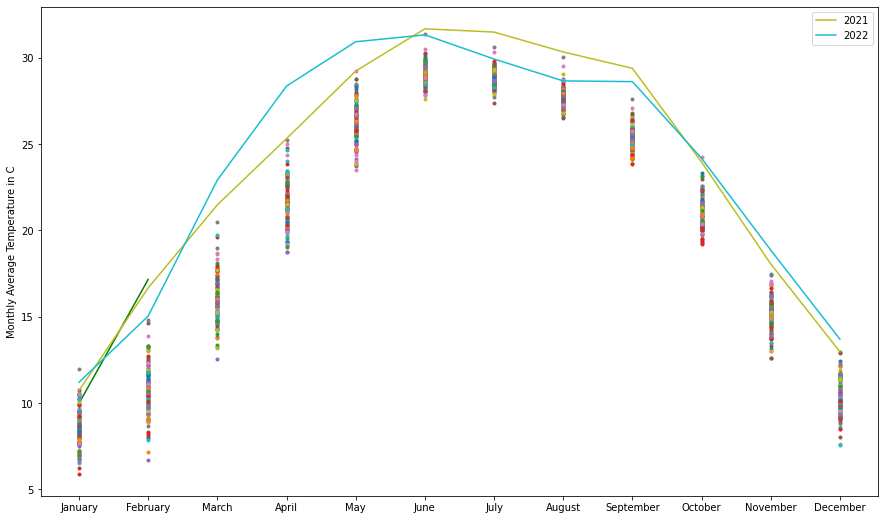

In [6]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.figure(figsize=(15,9))
plt.plot(months[:2], temps2023, '-', c='green')
for year in range(1901, 2023):
    if year in [2020, 2019]:
        continue
    if year in [2021, 2022]:
        plt.plot(months, temperatures[temperatures[" Year"] == year]["Temperature - (Celsius)"], '-', label=f'{year}')
        continue
    plt.plot(months, temperatures[temperatures[" Year"] == year]["Temperature - (Celsius)"], '.')
plt.legend()
plt.ylabel("Monthly Average Temperature in C")
plt.show()

In [7]:
temperatures.groupby([' Year'], axis=0, as_index=False).mean().corr()

,Year,Temperature - (Celsius)
Year,1.000000,0.565171
Temperature - (Celsius),0.565171,1.000000


In [8]:
meanAll = temperatures[(temperatures['Month'].isin(months)) & (temperatures[' Year'] != 2023)].groupby([' Year'], as_index=False).mean()['Temperature - (Celsius)']
meanAll

0      20.060848
1      20.406836
2      19.464821
3      19.970376
4      19.448188
         ...    
115    21.414617
116    22.317500
117    22.755417
118    23.442500
119    23.644167
Name: Temperature - (Celsius), Length: 120, dtype: float64

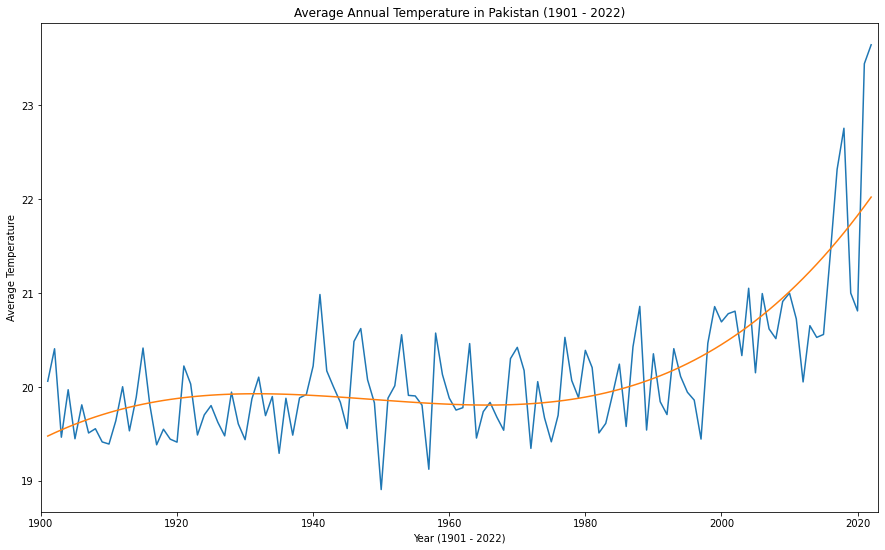

In [9]:
#fill missing data: 2019 2020 
meanAll2 = meanAll[:-2].tolist() + [21, 20.81] + meanAll[-2:].tolist()

plt.figure(figsize=(15,9))
plt.plot(list(range(1901,2023)), meanAll2)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

pol = PolynomialFeatures(degree=5).fit_transform(np.array(list(range(1901,2023))).reshape(-1, 1))
model = LinearRegression()
model.fit(pol, meanAll2)
plt.plot(list(range(1901,2023)), model.predict(pol))# model.intercept_ + model.coef_ * np.array(list(range(1901,2017))))
plt.xlabel("Year (1901 - 2022)")
plt.ylabel("Average Temperature")
plt.xlim([1900, 2023])
plt.title("Average Annual Temperature in Pakistan (1901 - 2022)")
plt.show()

### Model Building

In [347]:
## 122 years of data
len(meanAll2)

122

In [348]:
temperatures = pd.Series(meanAll2)
temperatures = temperatures.values.astype("float32")

In [349]:
temperature_data = temperatures

In [350]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(temperature_data.reshape(-1, 1))

In [351]:
# Prepare the dataset for RNN
def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

In [352]:
look_back = 10
X, Y = create_dataset(normalized_data, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into train and test sets
train_size = int(len(X) * 0.88)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:]
Y_train, Y_test = Y[0:train_size], Y[train_size:]

In [353]:
# Create the RNN model
model = Sequential()
model.add(LSTM(32, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

# Train the model
model.fit(X_train, 
          Y_train, 
          epochs=130, 
          batch_size=1, 
          verbose=2)

Epoch 1/130
98/98 - 2s - loss: 0.0083 - 2s/epoch - 25ms/step
Epoch 2/130
98/98 - 0s - loss: 0.0083 - 441ms/epoch - 4ms/step
Epoch 3/130
98/98 - 0s - loss: 0.0080 - 446ms/epoch - 5ms/step
Epoch 4/130
98/98 - 0s - loss: 0.0081 - 428ms/epoch - 4ms/step
Epoch 5/130
98/98 - 0s - loss: 0.0082 - 426ms/epoch - 4ms/step
Epoch 6/130
98/98 - 0s - loss: 0.0081 - 425ms/epoch - 4ms/step
Epoch 7/130
98/98 - 0s - loss: 0.0077 - 428ms/epoch - 4ms/step
Epoch 8/130
98/98 - 0s - loss: 0.0082 - 440ms/epoch - 4ms/step
Epoch 9/130
98/98 - 0s - loss: 0.0080 - 420ms/epoch - 4ms/step
Epoch 10/130
98/98 - 0s - loss: 0.0089 - 445ms/epoch - 5ms/step
Epoch 11/130
98/98 - 0s - loss: 0.0073 - 430ms/epoch - 4ms/step
Epoch 12/130
98/98 - 0s - loss: 0.0089 - 427ms/epoch - 4ms/step
Epoch 13/130
98/98 - 0s - loss: 0.0082 - 427ms/epoch - 4ms/step
Epoch 14/130
98/98 - 0s - loss: 0.0080 - 431ms/epoch - 4ms/step
Epoch 15/130
98/98 - 0s - loss: 0.0080 - 426ms/epoch - 4ms/step
Epoch 16/130
98/98 - 0s - loss: 0.0081 - 422ms/epoc

In [354]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions (de normalization)
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

1/1 [==============================] - 0s 27ms/step


In [355]:
# Calculate mean squared error
train_score = mean_squared_error(Y_train[0], train_predict[:, 0])
print(f"Train Score: {train_score:.2f} MSE")
test_score = mean_squared_error(Y_test[0], test_predict[:, 0])
print(f"Test Score: {test_score:.2f} MSE")

Train Score: 0.13 MSE
Test Score: 1.44 MSE


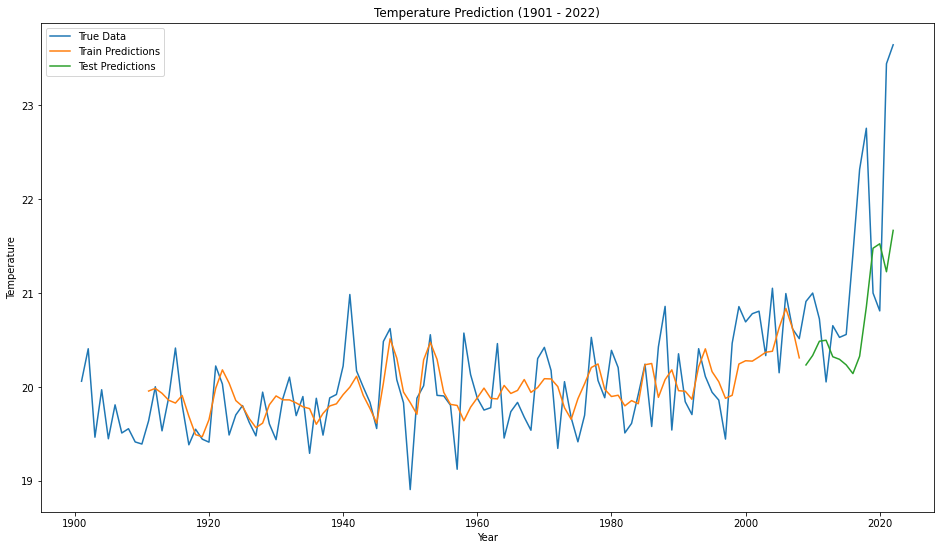

In [356]:
# Plot the results
def plot_results(true_data, train_predict, test_predict, look_back):
    plt.figure(figsize=(16, 9))
    plt.plot(list(range(1901, 2023)),true_data, label="True Data")
    plt.plot(
        np.arange(1901 + look_back, 1901 + look_back + len(train_predict)),
        train_predict,
        label="Train Predictions",
    )
    plt.plot(
        np.arange(1901 + look_back + len(train_predict), 1901 + len(true_data)),
        test_predict,
        label="Test Predictions",
    )
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    plt.legend()
    plt.title("Temperature Prediction (1901 - 2022)")
    plt.show()


plot_results(temperature_data, train_predict, test_predict, look_back)